# Custmoer Churn project 
# from https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset

## 0. Package and Environment

In [172]:
# checking environment
import sys
print(sys.executable)

c:\Users\user\anaconda3\envs\torch311\python.exe


In [173]:
# import neccessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from itertools import product
import random

In [174]:
# checking gpu
print("torch:", torch.__version__)
print("cuda version:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("device:", torch.cuda.get_device_name(0))

torch: 2.5.1+cu121
cuda version: 12.1
cuda available: True
device: NVIDIA GeForce RTX 4070 Laptop GPU


## 1.1 Import dataset and Data cleaning

In [175]:
# Since training set and test set are seperate, so combine them first and then do split later
df = pd.concat([pd.read_csv("training_set.csv"),
                pd.read_csv("test_set.csv")],
                axis=0)
df.reset_index(drop=True, inplace=True)
df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [176]:
df.describe()

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000,505206.000000
mean,200779.451782,39.704172,31.350435,15.714825,3.833317,13.496843,620.072766,14.610581,0.555203
std,137241.343095,12.670577,17.237482,8.619323,3.133603,8.451187,245.319256,8.608286,0.496944
min,1.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,63827.250000,29.000000,16.000000,8.000000,1.000000,6.000000,446.000000,7.000000,0.000000
50%,193039.500000,40.000000,32.000000,16.000000,3.000000,13.000000,648.900000,14.000000,1.000000
75%,321645.750000,49.000000,46.000000,23.000000,6.000000,20.000000,824.000000,22.000000,1.000000
max,449999.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505207 entries, 0 to 505206
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         505206 non-null  float64
 1   Age                505206 non-null  float64
 2   Gender             505206 non-null  object 
 3   Tenure             505206 non-null  float64
 4   Usage Frequency    505206 non-null  float64
 5   Support Calls      505206 non-null  float64
 6   Payment Delay      505206 non-null  float64
 7   Subscription Type  505206 non-null  object 
 8   Contract Length    505206 non-null  object 
 9   Total Spend        505206 non-null  float64
 10  Last Interaction   505206 non-null  float64
 11  Churn              505206 non-null  float64
dtypes: float64(9), object(3)
memory usage: 46.3+ MB


In [178]:
# removing unnecessary colum
df.drop(columns='CustomerID', inplace=True)

In [179]:
df.shape

(505207, 11)

In [180]:
# count missing values
df.isnull().sum()

Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

In [181]:
# check which index data have missing value 
df[df.isna().any(axis=1)]

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
199295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [182]:
# Since only one data with missing value, we can just remove it
df.dropna(inplace=True)

In [183]:
print(df.shape)
df.head()

(505206, 11)


,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


## 1.2 EDA

### 1.2.1 Univarient Analysis

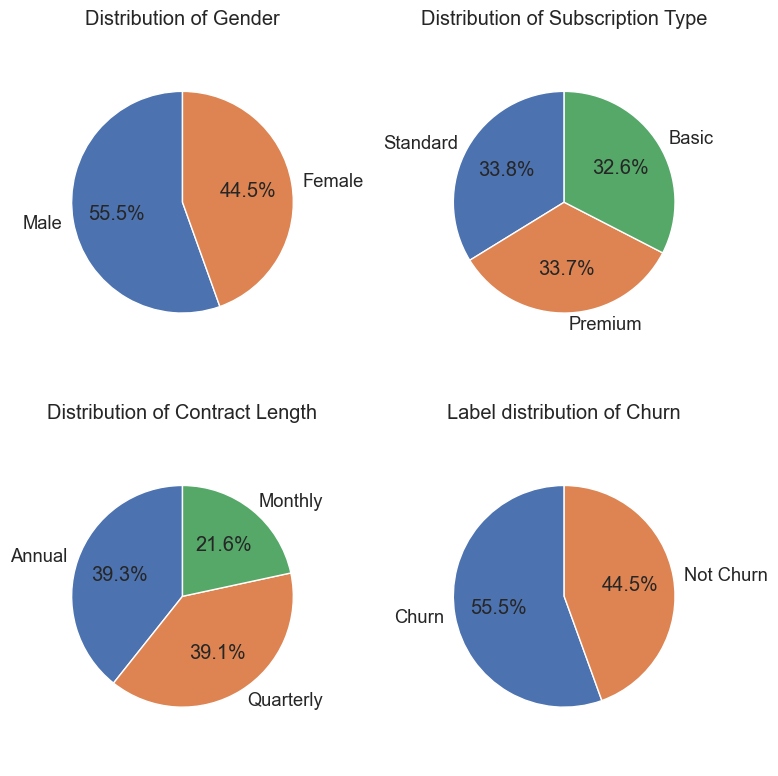

In [184]:
# Categorical Data
categorical_cols = ["Gender","Subscription Type","Contract Length","Churn"]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
# Flatten it to be 1D array for for_loop
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    
    # Mapping churn 
    if col == "Churn":
        churn_mapping = {0: "Not Churn", 1: "Churn"}
        counts = df[col].map(churn_mapping).value_counts()
    else:
        counts = df[col].value_counts()

    ax.pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=90)
    if col == "Churn":
        ax.set_title(f"Label distribution of {col}")
    else:
        ax.set_title(f"Distribution of {col}")
    ax.axis("equal")

plt.tight_layout()
plt.show()
    

### ! important : ratio of Churn and Not Churn is 55.5 to 44.5, so we could say there is no class imbalance problem.

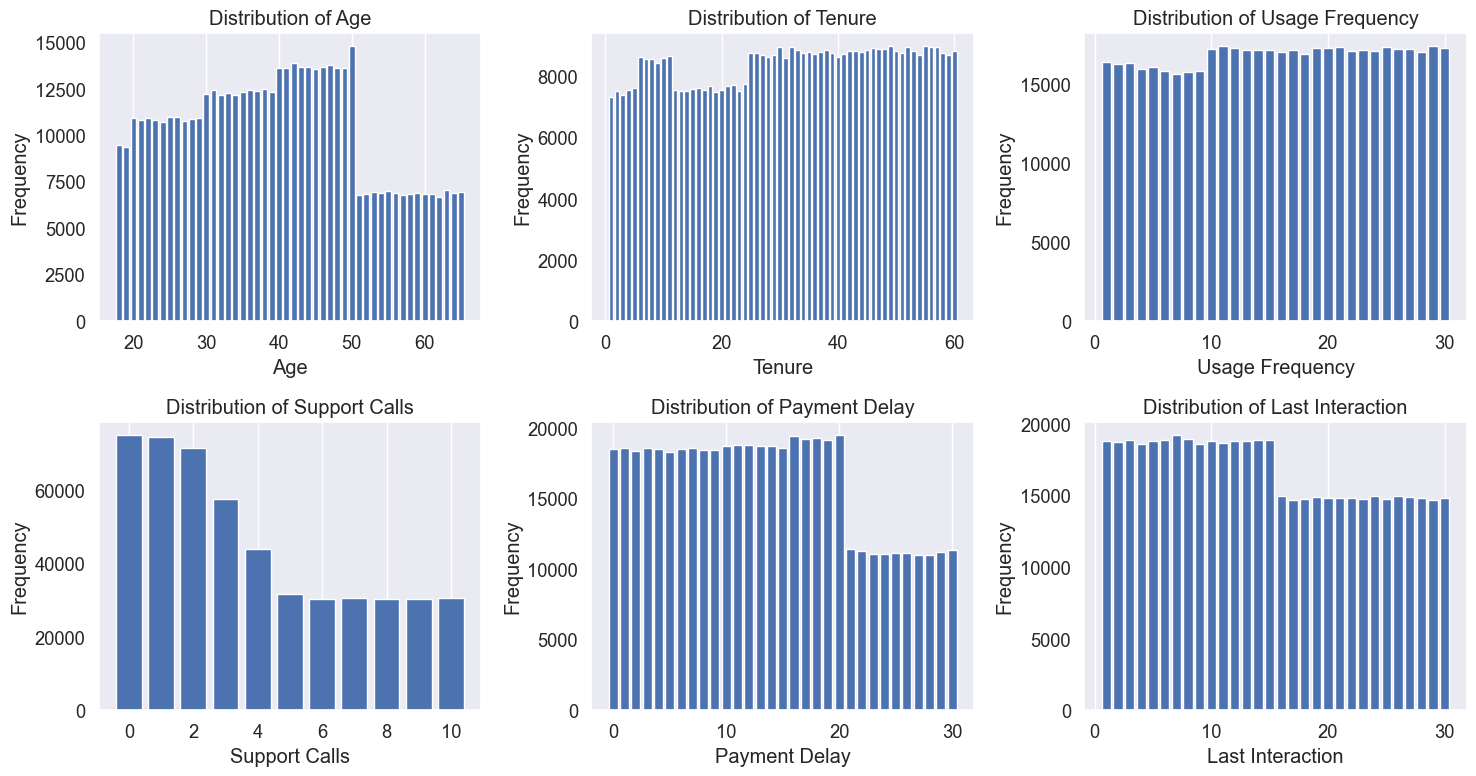

In [185]:
# Discrete Data
discrete_cols = ["Age","Tenure","Usage Frequency","Support Calls","Payment Delay","Last Interaction"]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(discrete_cols):
    ax = axes[i]
    counts = df[col].value_counts().sort_index()

    ax.bar(counts.index, counts.values)
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.grid(axis="y")

plt.tight_layout()
plt.show()



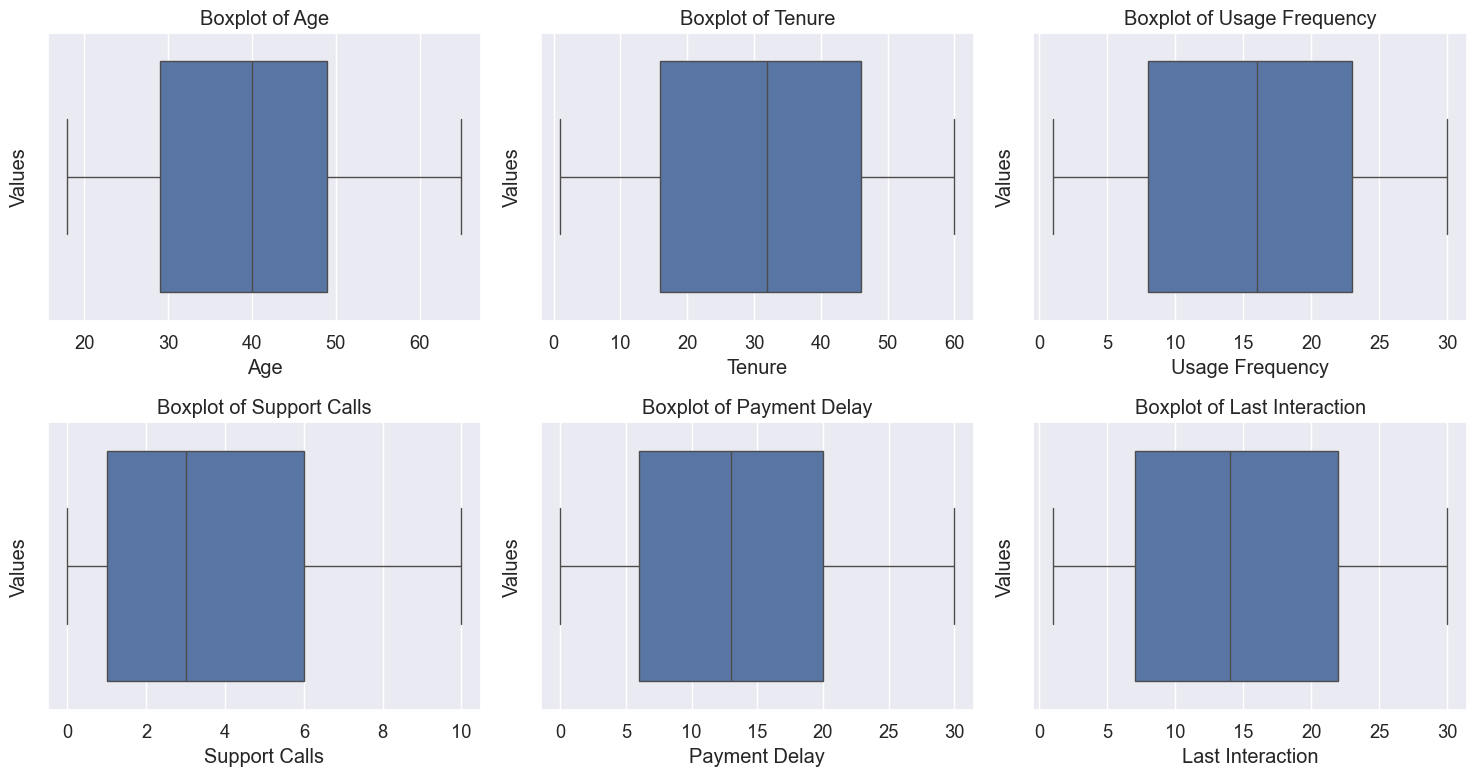

In [186]:
# Boxplot for Discrete Data
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(discrete_cols):
    ax = axes[i]
    sns.boxplot(data=df, x=col, ax=ax)
    ax.set_title(f"Boxplot of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Values")

plt.tight_layout()
plt.show()

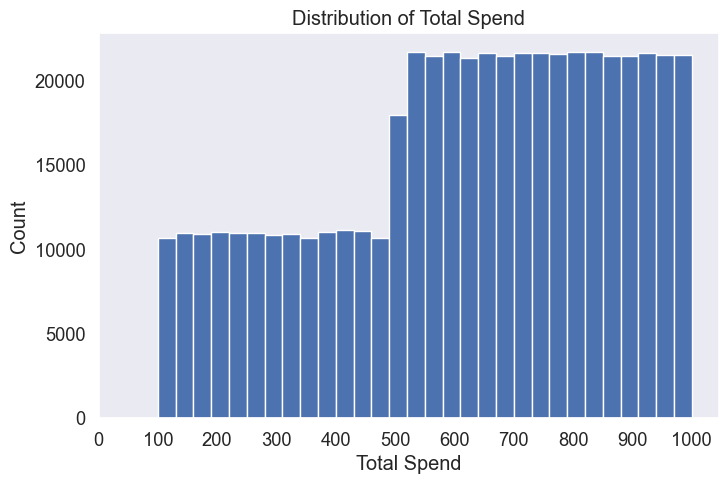

In [187]:
# Continuous Data
continuous_col = "Total Spend"
plt.figure(figsize=(8, 5))
plt.hist(df[continuous_col], bins=30)
plt.xticks(range(0, 1001, 100))
plt.ylabel('Count')
plt.xlabel(continuous_col)
plt.title(f"Distribution of {continuous_col}")
plt.grid()
plt.show()

### 1.2.2 Mutivarient Analysis(Each features based on Target)

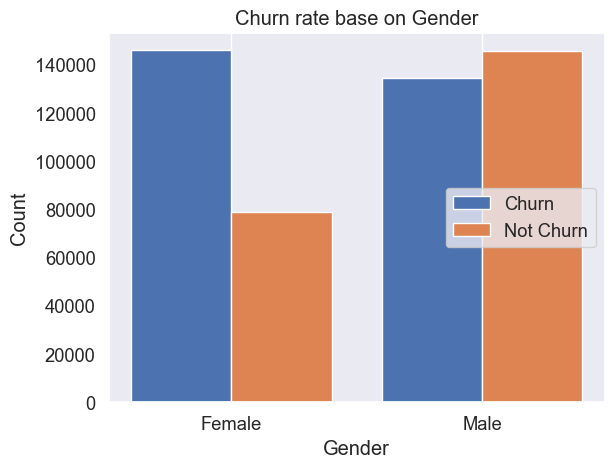

In [188]:
gender_churn = df.groupby(['Gender', 'Churn']).size().unstack()

X = list(gender_churn.index)
churn_0 = list(gender_churn.iloc[:, 0])
churn_1 = list(gender_churn.iloc[:, 1])
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, churn_1, 0.4, label = 'Churn')
plt.bar(X_axis + 0.2, churn_0, 0.4, label = 'Not Churn')
  
plt.xticks(X_axis, X)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title("Churn rate base on Gender")
plt.legend(loc='center right')
plt.grid(axis='y')
plt.show()

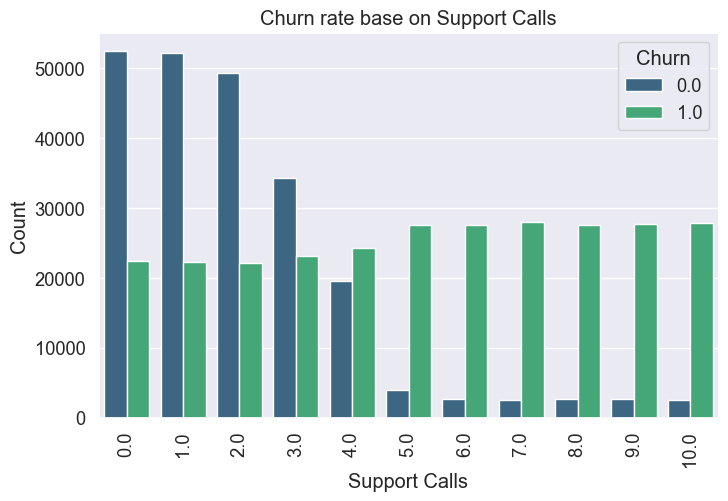

In [189]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Support Calls', hue='Churn', palette='viridis')
plt.xlabel('Support Calls')
plt.ylabel('Count')
plt.title('Churn rate base on Support Calls')
plt.xticks(rotation=90)
plt.show()

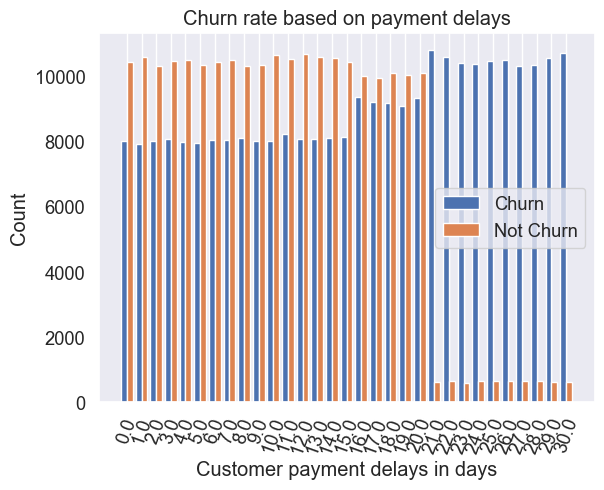

In [190]:
filtered = df.groupby(['Payment Delay', 'Churn']).size().unstack()

X = list(filtered.index)
churn_0 = list(filtered.iloc[:, 0])
churn_1 = list(filtered.iloc[:, 1])
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, churn_1, 0.4, label = 'Churn')
plt.bar(X_axis + 0.2, churn_0, 0.4, label = 'Not Churn')
  
plt.xticks(X_axis, X, rotation=70)
plt.xlabel("Customer payment delays in days")
plt.ylabel('Count')
plt.title("Churn rate based on payment delays")
plt.legend(loc='center right')
plt.grid(axis='y')
plt.show()

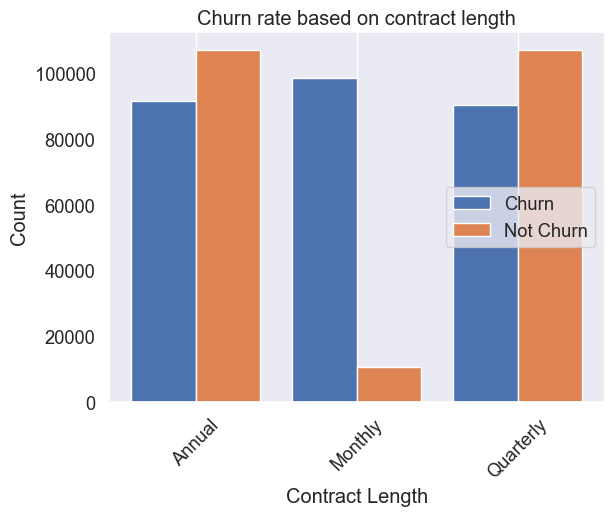

In [191]:

filtered = df.groupby(['Contract Length', 'Churn']).size().unstack()

X = list(filtered.index)
churn_0 = list(filtered.iloc[:, 0])
churn_1 = list(filtered.iloc[:, 1])
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, churn_1, 0.4, label = 'Churn')
plt.bar(X_axis + 0.2, churn_0, 0.4, label = 'Not Churn')
  
plt.xticks(X_axis, X, rotation=45)
plt.xlabel('Contract Length')
plt.ylabel('Count')
plt.title("Churn rate based on contract length")
plt.legend(loc='center right')
plt.grid(axis='y')
plt.show()

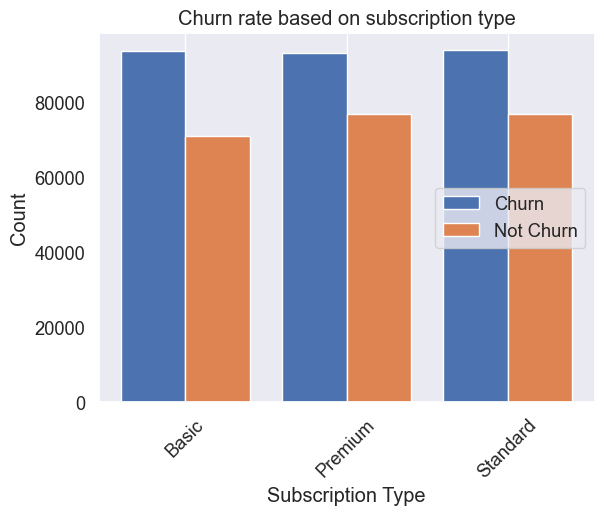

In [192]:
filtered = df.groupby(['Subscription Type', 'Churn']).size().unstack()

X = list(filtered.index)
churn_0 = list(filtered.iloc[:, 0])
churn_1 = list(filtered.iloc[:, 1])
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, churn_1, 0.4, label = 'Churn')
plt.bar(X_axis + 0.2, churn_0, 0.4, label = 'Not Churn')
  
plt.xticks(X_axis, X, rotation=45)
plt.xlabel('Subscription Type')
plt.ylabel('Count')
plt.title("Churn rate based on subscription type")
plt.legend(loc='center right')
plt.grid(axis='y')
plt.show()

### 1.2.3 Correlation

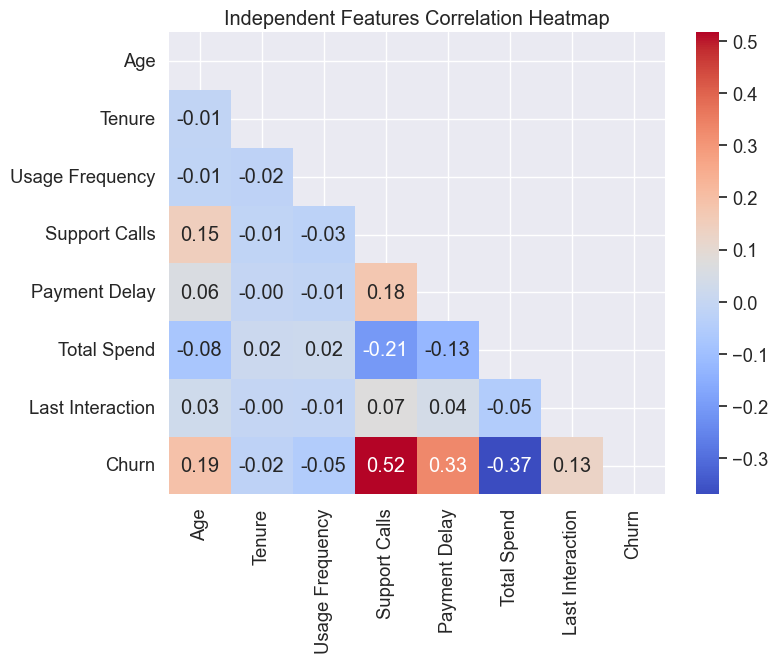

In [193]:
# select cols that datatype is number
features_df = df.select_dtypes(include=['number']).copy()
corr_matrix = features_df.corr()

# Creating a mask to hide the upper triangle of the heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.title("Independent Features Correlation Heatmap")
plt.show()

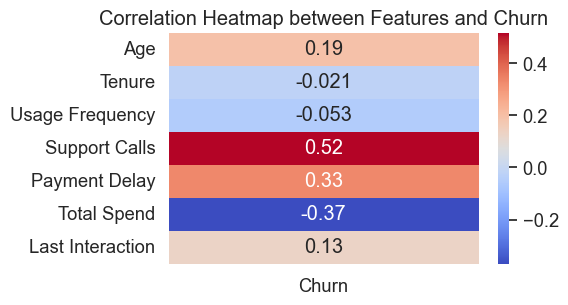

In [194]:
# choose correlation between cols with numerical data and label Churn 
correlation_data = df.select_dtypes(include=['number']).corr().loc[:'Last Interaction', 'Churn']
# -> become Series
# Create a heatmap
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.2)
# change correlation_data(Series) to DataFrame
sns.heatmap(correlation_data.to_frame(), annot=True, cmap="coolwarm", cbar=True)

plt.title("Correlation Heatmap between Features and Churn")
plt.show()

### 1.3 Data Preprocessing before Model Traning

#### Step 1. **Split X and y**  
Separate the **features (X)** and the **target label (y)**.

#### Step 2. **One-Hot Encode Categorical Features**  
Convert **categorical variables** into **numeric dummy variables**.

#### Step 3. **Split the Dataset** into **Training (80%)**, **Validation (10%)**, and **Test (10%)** sets  
Perform the split **before scaling** to avoid **data leakage**.

#### Step 4. **Standardize Features**  
**Fit** the scaler only on the **training set**, then **apply** the same transformation to **validation** and **test** sets.

#### Step 5. **Convert to PyTorch Tensors**  
Transform the **NumPy arrays** into **PyTorch tensors** for model input.

In [195]:
df.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [196]:
# Spliting features and label
X = df.drop('Churn', axis=1)
y = df['Churn']

In [197]:
# Select cattegorical data in X
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", list(categorical_cols))

# Do one-hot encoding on categorical data and transform to 1 and 0
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True).astype(int)
print(X_encoded.shape)
X_encoded.head()

Categorical columns: ['Gender', 'Subscription Type', 'Contract Length']
(505206, 12)


,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Gender_Male,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Monthly,Contract Length_Quarterly
0,30,39,14,5,18,932,17,0,0,1,0,0
1,65,49,1,10,8,557,6,0,0,0,1,0
2,55,14,4,6,18,185,3,0,0,0,0,1
3,58,38,21,7,7,396,29,1,0,1,1,0
4,23,32,20,5,8,617,20,1,0,0,1,0


In [198]:
# Split off the test set (10%)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_encoded, y,
    test_size=0.1,           # 10% for testing
    random_state=42,         # for reproducibility
    stratify=y               # keep churn ratio same in all sets
)

#  Split the remaining 90% into train (80%) and validation (10%)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.1111,        # 0.1111 × 0.9 ≈ 0.1 (so val is 10% total)
    random_state=42,
    stratify=y_trainval
)

print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

Training set: (404169, 12)
Validation set: (50516, 12)
Test set: (50521, 12)


In [199]:
# Create the scaler
scaler = StandardScaler()

# Fit ONLY on training data
scaler.fit(X_train)

# Apply the same transformation to all sets
X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

In [200]:
# Convert features (X) and labels (y) into tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1) # reshape y into column vector (m,1)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

print(X_train_tensor.shape, y_train_tensor.shape)
print(X_val_tensor.shape, y_val_tensor.shape)
print(X_test_tensor.shape, y_test_tensor.shape)

torch.Size([404169, 12]) torch.Size([404169, 1])
torch.Size([50516, 12]) torch.Size([50516, 1])
torch.Size([50521, 12]) torch.Size([50521, 1])


## 2.1 Build Model


### 2.1.1 Create Dataloaders and Minibatch

In [201]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

g = torch.Generator()
g.manual_seed(seed)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, generator=g)
val_loader   = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=512, shuffle=False)
print(len(train_loader),"batches in training set")
print(len(val_loader),"batches in validation set")
print(len(test_loader),"batches in testing set")

790 batches in training set
99 batches in validation set
99 batches in testing set


### 2.1.2 Define Hyperparameter 

In [202]:
hyperparams = {
    "batchnorm_options": [True, False],
    "learning_rates": [0.001],
    "batch_sizes": [512],
    "dropouts": [0.2],
    "hidden_layers_list": [
        [128, 64, 32, 16],
        [256, 128, 64, 32]
    ],
    "optimizers": ["Adam"],
    "l2_weight_decays": [0, 1e-5, 1e-4],
    "l1_lambdas": [0, 1e-6, 1e-5],
    "epochs": [10]
}


### 2.1.3 Build the Neural Network

In [203]:
class ChurnNet(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout_rate, use_batchnorm):
        super(ChurnNet, self).__init__()
        layers = []
        prev_dim = input_dim

        for h in hidden_layers:
            layers.append(nn.Linear(prev_dim, h))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h))  # Batch Normalization (optional)
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = h

        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

### 2.1.4 Build Training Function

In [204]:
def train_model(model, optimizer, criterion, train_loader, val_loader,
                l1_lambda, epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on: {device}")
    model.to(device)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        correct_train, total_train = 0, 0

        # -------- Training loop --------
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)            # shape: [batch_size, 1]
            loss = criterion(outputs, y_batch)

            # L1 regularization
            if l1_lambda > 0:
                l1_norm = 0.0
                for p in model.parameters():
                    l1_norm += p.abs().sum()
                loss = loss + l1_lambda * l1_norm

            loss.backward()
            optimizer.step() # Update weightS
            total_loss += loss.item()

            # Training accuracy
            preds = (outputs > 0.5).float()
            correct_train += (preds == y_batch).sum().item()
            total_train += y_batch.size(0)

        avg_train_loss = total_loss / len(train_loader)
        train_acc = correct_train / total_train

        # -------- Validation loop --------
        model.eval() # in eval not use dropout and norlbatch
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                preds = model(X_val)
                loss = criterion(preds, y_val)
                val_loss += loss.item()

                pred_labels = (preds > 0.5).float()
                correct_val += (pred_labels == y_val).sum().item()
                total_val += y_val.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct_val / total_val

        # store history
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(
            f"Epoch [{epoch+1}/{epochs}] "
            f"Train Loss: {avg_train_loss:.4f}  "
            f"Val Loss: {avg_val_loss:.4f}  "
            f"Train Acc: {train_acc:.4f}  "
            f"Val Acc: {val_acc:.4f}"
        )

    # return everything you need
    return train_losses, val_losses, train_accs, val_accs, val_acc


### 2.1.5 Run Hyperparameter Tuning Loop

In [205]:
# best_acc = 0.0
# best_config = None

# # pick single values from lists (since you only use 1 lr, 1 batch_size, 1 dropout now)
# lr = hyperparams["learning_rates"][0]
# dropout_rate = hyperparams["dropouts"][0]
# batch_size = hyperparams["batch_sizes"][0]
# epochs = hyperparams["epochs"][0]  # or set in hyperparams if you want

# for use_batchnorm, hidden_layers, l2, l1 in product(
#     hyperparams["batchnorm_options"],
#     hyperparams["hidden_layers_list"],
#     hyperparams["l2_weight_decays"],
#     hyperparams["l1_lambdas"]
# ):
#     print(f"\n🔹 Config: BatchNorm={use_batchnorm}, Hidden={hidden_layers}, L2={l2}, L1={l1}")

#     # Model
#     model = ChurnNet(
#         input_dim=12,
#         hidden_layers=hidden_layers,
#         dropout_rate=dropout_rate,
#         use_batchnorm=use_batchnorm
#     )

#     # Optimizer with L2 (weight decay)
#     optimizer = optim.Adam(
#         model.parameters(),
#         lr=lr,
#         weight_decay=l2
#     )
#     criterion = nn.BCELoss()

#     # Train and validate (pass L1 into train_model)
#     train_losses, val_losses, train_accs, val_accs, val_acc = train_model(
#         model, optimizer, criterion,
#         train_loader, val_loader,
#         l1_lambda=l1,
#         epochs=epochs
#     )

#     # Track best configuration
#     if val_acc > best_acc:
#         best_acc = val_acc
#         best_config = {
#             "BatchNorm": use_batchnorm,
#             "Hidden Layers": hidden_layers,
#             "Dropout": dropout_rate,
#             "Learning Rate": lr,
#             "L2": l2,
#             "L1": l1,
#             "Batch Size": batch_size,
#             "Optimizer": "Adam"
#         }

# print("\n✅ Best configuration found:")
# print(best_config)
# print(f"Validation Accuracy: {best_acc:.4f}")

✅ **Best Configuration Found**

- **BatchNorm**: False  
- **Hidden Layers**: [128, 64, 32, 16]  
- **Dropout**: 0.2  
- **Learning Rate**: 0.001  
- **L2 (weight decay)**: 1e-05  
- **L1 (lambda)**: 1e-05  
- **Batch Size**: 512  
- **Optimizer**: Adam  

**Validation Accuracy**: **0.9331**

### 2.1.6 Best model

In [206]:
best_model = ChurnNet(
    input_dim=12,                      # 12 features
    hidden_layers=[128, 64, 32, 16],  # from best config
    dropout_rate=0.2,
    use_batchnorm=False                # BatchNorm: False
)

criterion = nn.BCELoss()

optimizer = optim.Adam(
    best_model.parameters(),
    lr=0.001,          # Learning Rate
    weight_decay=1e-5  # L2
)

l1 = 1e-5       # L1
epochs = 20     # e.g. train a bit longer for final model

# Training !
train_losses, val_losses, train_accs, val_accs, val_acc = train_model(
    best_model, optimizer, criterion,
    train_loader, val_loader,
    l1_lambda=l1,
    epochs=epochs
)

Training on: cuda
Epoch [1/20] Train Loss: 0.3163  Val Loss: 0.2403  Train Acc: 0.8898  Val Acc: 0.9205
Epoch [2/20] Train Loss: 0.2477  Val Loss: 0.2175  Train Acc: 0.9236  Val Acc: 0.9286
Epoch [3/20] Train Loss: 0.2306  Val Loss: 0.2106  Train Acc: 0.9298  Val Acc: 0.9303
Epoch [4/20] Train Loss: 0.2230  Val Loss: 0.2067  Train Acc: 0.9317  Val Acc: 0.9318
Epoch [5/20] Train Loss: 0.2180  Val Loss: 0.2037  Train Acc: 0.9327  Val Acc: 0.9322
Epoch [6/20] Train Loss: 0.2149  Val Loss: 0.2025  Train Acc: 0.9331  Val Acc: 0.9321
Epoch [7/20] Train Loss: 0.2122  Val Loss: 0.1998  Train Acc: 0.9334  Val Acc: 0.9327
Epoch [8/20] Train Loss: 0.2105  Val Loss: 0.1987  Train Acc: 0.9334  Val Acc: 0.9328
Epoch [9/20] Train Loss: 0.2082  Val Loss: 0.1971  Train Acc: 0.9336  Val Acc: 0.9326
Epoch [10/20] Train Loss: 0.2072  Val Loss: 0.1956  Train Acc: 0.9335  Val Acc: 0.9328
Epoch [11/20] Train Loss: 0.2057  Val Loss: 0.1978  Train Acc: 0.9336  Val Acc: 0.9322
Epoch [12/20] Train Loss: 0.2045  

### 2.1.7 Plot Train Loss vs Val Loss & Train acc vs Val acc

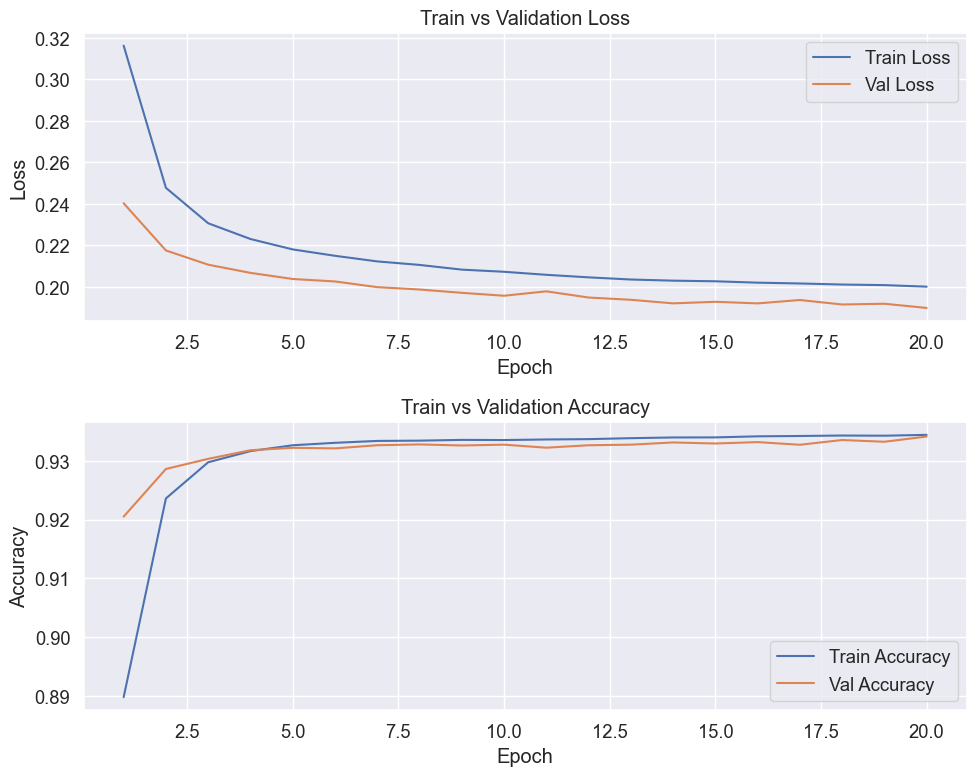

In [207]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 8))

# ---- Loss plot ----
plt.subplot(2, 1, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)

# ---- Accuracy plot ----
plt.subplot(2, 1, 2)
plt.plot(epochs_range, train_accs, label="Train Accuracy")
plt.plot(epochs_range, val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 2.2 Model Evaluation

### 2.2.1 Make predictions on test set

In [208]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.to(device)
best_model.eval()

all_probs = []
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:   # <- use your test_loader here
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        probs = best_model(X_batch).view(-1)          # sigmoid outputs
        preds = (probs > 0.5).float()                 # threshold at 0.5

        all_probs.append(probs.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y_batch.view(-1).cpu().numpy())

all_probs = np.concatenate(all_probs)
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

### 2.2.2 Check if model overfitting

Train Accuracy: 0.9357991335307755
Val   Accuracy: 0.9341396785176974
Test  Accuracy: 0.935987015300568


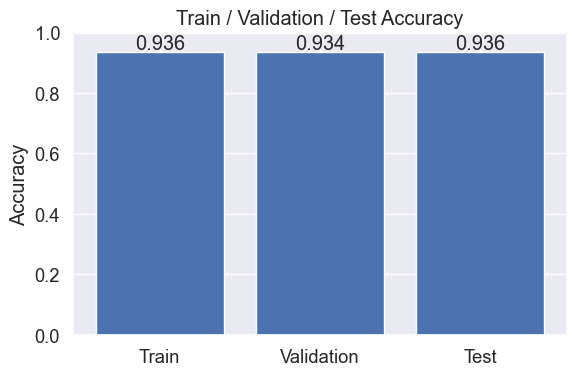

In [209]:
def evaluate_accuracy(model, data_loader, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            probs = model(X_batch).view(-1)          # sigmoid outputs
            preds = (probs > 0.5).float()            # threshold 0.5

            all_preds.append(preds.cpu())
            all_targets.append(y_batch.view(-1).cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    acc = accuracy_score(all_targets, all_preds)
    return acc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_acc_final = evaluate_accuracy(best_model, train_loader, device)
val_acc_final   = evaluate_accuracy(best_model, val_loader, device)
test_acc_final  = evaluate_accuracy(best_model, test_loader, device)

print("Train Accuracy:", train_acc_final)
print("Val   Accuracy:", val_acc_final)
print("Test  Accuracy:", test_acc_final)
import matplotlib.pyplot as plt

acc_names  = ["Train", "Validation", "Test"]
acc_values = [train_acc_final, val_acc_final, test_acc_final]

plt.figure(figsize=(6, 4))
plt.bar(acc_names, acc_values)
plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
plt.title("Train / Validation / Test Accuracy")
for i, v in enumerate(acc_values):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center")

plt.tight_layout()
plt.show()


### 2.2.3 Compute metrics

=== Test Metrics ===
Accuracy : 0.9360
Precision: 0.8980
Recall   : 0.9981
F1 Score : 0.9454
AUC-ROC  : 0.9523
Confusion Matrix:
 [[19292  3180]
 [   54 27995]]


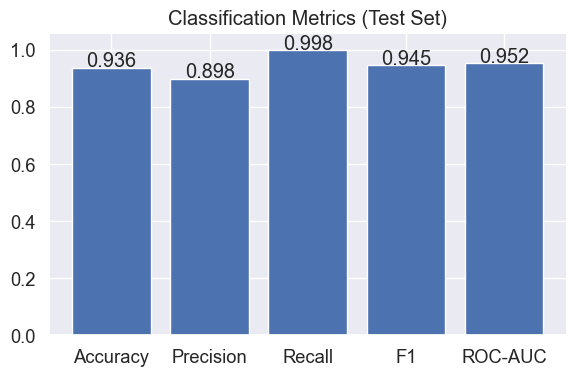

In [210]:
test_acc  = accuracy_score(all_targets, all_preds)
prec = precision_score(all_targets, all_preds)
rec  = recall_score(all_targets, all_preds)
f1   = f1_score(all_targets, all_preds)
auc  = roc_auc_score(all_targets, all_probs)
cm   = confusion_matrix(all_targets, all_preds)

print("=== Test Metrics ===")
print(f"Accuracy : {test_acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC-ROC  : {auc:.4f}")
print("Confusion Matrix:\n", cm)

metric_names  = ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]
metric_values = [test_acc, prec, rec, f1, auc]

plt.figure(figsize=(6, 4))
plt.bar(metric_names, metric_values)
plt.ylim(0, 1.06)
plt.title("Classification Metrics (Test Set)")
for i, v in enumerate(metric_values):
    plt.text(i, v + 0.005, f"{v:.3f}", ha="center")
plt.tight_layout()
plt.show()

### 2.2.4 Confusion Matrix Heatmap

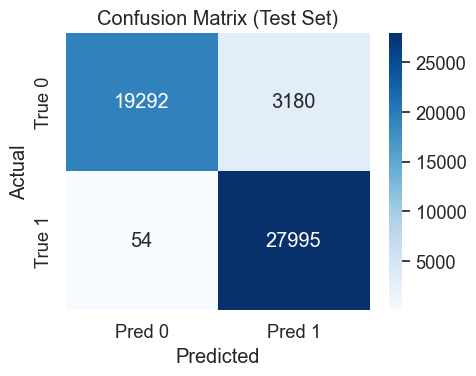

In [211]:
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()

### 2.2.5 ROC Curve

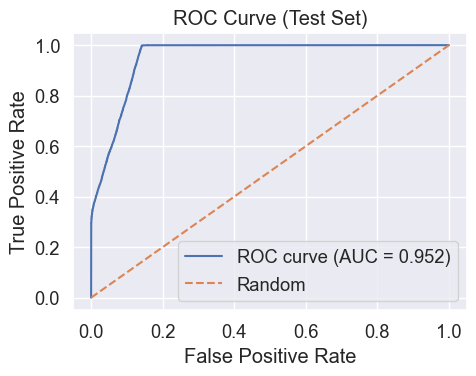

In [212]:
fpr, tpr, _ = roc_curve(all_targets, all_probs)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 2.2.6 Permutation Importance

Base ROC-AUC on test: 0.9523


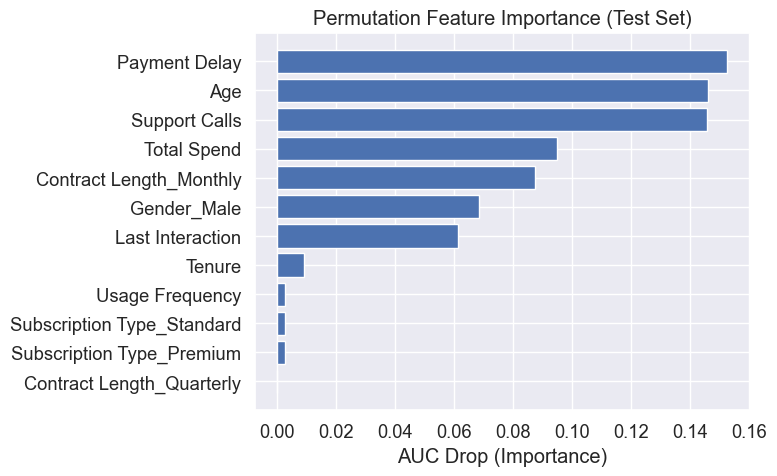

In [213]:
feature_names = X_train.columns.tolist()
X_test_np = np.array(X_test_scaled)           # shape: [N_test, 12]
y_test_np = np.array(y_test).astype(np.float32)

# ---- helper: compute AUC for given X, y ----
def compute_auc(model, X_np, y_np):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X_np, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y_np, dtype=torch.float32).to(device)

        probs = model(X_tensor).view(-1)          # sigmoid outputs
        probs_np = probs.cpu().numpy()
        return roc_auc_score(y_np, probs_np)

# 1. Base AUC on original TEST set
base_auc = compute_auc(best_model, X_test_np, y_test_np)
print(f"Base ROC-AUC on test: {base_auc:.4f}")

# 2. Permutation importance for each feature (on TEST)
n_features = X_test_np.shape[1]
importances = []

for j in range(n_features):
    X_perm = X_test_np.copy()
    # shuffle column j
    np.random.shuffle(X_perm[:, j])
    perm_auc = compute_auc(best_model, X_perm, y_test_np)
    drop = base_auc - perm_auc
    importances.append(drop)

importances = np.array(importances)

# 3. Plot feature importances (AUC drop on TEST set)
sorted_idx = np.argsort(importances)[::-1]  # largest drop first
sorted_names = [feature_names[i] for i in sorted_idx]
sorted_imps  = importances[sorted_idx]

plt.figure(figsize=(8, 5))
plt.barh(sorted_names, sorted_imps)
plt.xlabel("AUC Drop (Importance)")
plt.title("Permutation Feature Importance (Test Set)")
plt.gca().invert_yaxis()  # biggest at top
plt.tight_layout()
plt.show()

## Conclusion  

In this deep learning project, we trained an MLP neural network on a customer churn dataset to predict which customers are likely to churn and to understand which features contribute most to that decision.

### 1. EDA and Preprocessing  
We performed two main types of exploratory data analysis (EDA):

- **Univariate analysis**:  
  We plotted the distribution of each feature and the target variable to check for class imbalance and understand the basic characteristics of the data.

- **Multivariate analysis**:  
  We examined the relationship between the churn label and each feature, and then used a correlation heatmap to visualize how features are related to one another.

Before building the model, we:
- Applied **one-hot encoding** to convert categorical variables into numerical feature columns.  
- **Standardized** the training features so that the model could train more efficiently and avoid issues caused by different feature scales.

### 2. Model Construction  
We first defined a set of **hyperparameters**, deciding which ones to tune on the validation set (e.g., hidden layer sizes, regularization) and which ones to keep fixed.  
We then:

- Built the MLP architecture.
- Trained the model on the **training set** and evaluated it on the **validation set**.
- Selected the best hyperparameter configuration based on validation performance and retrained the final model using those settings.

### 3. Model Evaluation  
We applied the final model to the **test set** and:

- Checked for **overfitting** by comparing training, validation, and test accuracy/loss.
- Evaluated performance using common classification metrics such as **Accuracy, Precision, Recall, F1-score, and ROC-AUC**.

Since the model achieved consistently strong results across all splits, we additionally applied **Permutation Feature Importance** on the test set to identify which features most strongly affect model performance and churn prediction.
